Current working directory: c:\Users\nahun\OneDrive\Escritorio\Anyone\Final Project - NYC Taxi Fare and Trip Duration Prediction\nyc-taxi-predictor\notebooks
Resolved data path: C:\Users\nahun\OneDrive\Escritorio\Anyone\Final Project - NYC Taxi Fare and Trip Duration Prediction\nyc-taxi-predictor\data\raw
Found 12 matching files: ['yellow_tripdata_2022-01.parquet', 'yellow_tripdata_2022-02.parquet', 'yellow_tripdata_2022-03.parquet', 'yellow_tripdata_2022-04.parquet', 'yellow_tripdata_2022-05.parquet', 'yellow_tripdata_2022-06.parquet', 'yellow_tripdata_2022-07.parquet', 'yellow_tripdata_2022-08.parquet', 'yellow_tripdata_2022-09.parquet', 'yellow_tripdata_2022-10.parquet', 'yellow_tripdata_2022-11.parquet', 'yellow_tripdata_2022-12.parquet']
Loaded dataset with shape: (39656098, 19)


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.80,1.0,N,142,236,1,14.5,3.0,0.5,3.65,0.0,0.3,21.95,2.5,0.0
1,1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.10,1.0,N,236,42,1,8.0,0.5,0.5,4.00,0.0,0.3,13.30,0.0,0.0
2,2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.0,0.97,1.0,N,166,166,1,7.5,0.5,0.5,1.76,0.0,0.3,10.56,0.0,0.0
3,2,2022-01-01 00:25:21,2022-01-01 00:35:23,1.0,1.09,1.0,N,114,68,2,8.0,0.5,0.5,0.00,0.0,0.3,11.80,2.5,0.0
4,2,2022-01-01 00:36:48,2022-01-01 01:14:20,1.0,4.30,1.0,N,68,163,1,23.5,0.5,0.5,3.00,0.0,0.3,30.30,2.5,0.0


Column names: ['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'airport_fee']
Dataframe info (data types and non-null counts):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39656098 entries, 0 to 39656097
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type     

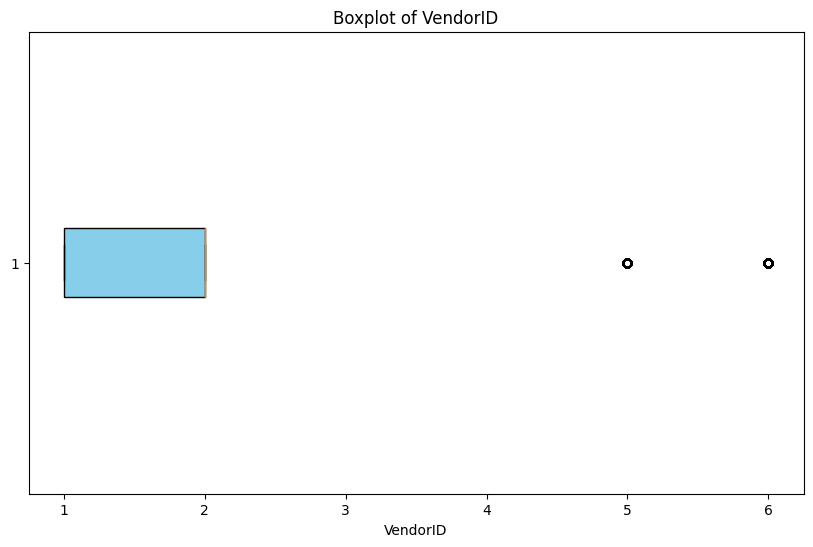

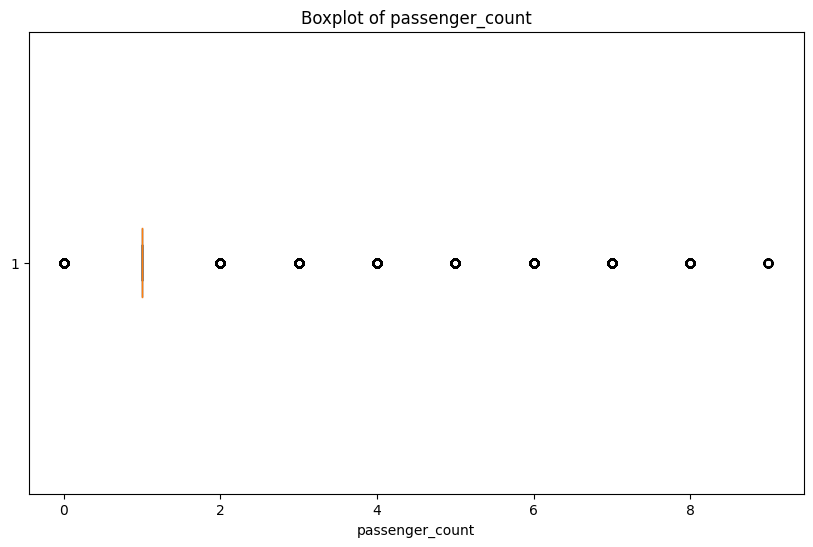

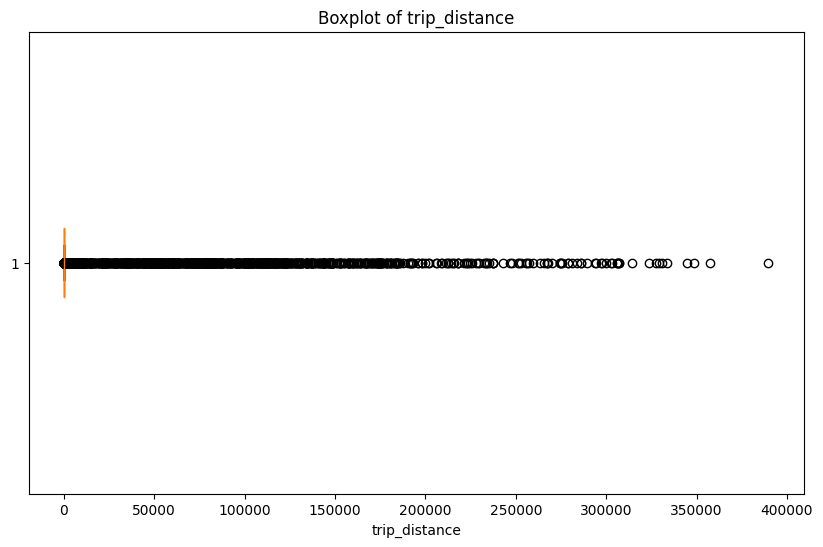

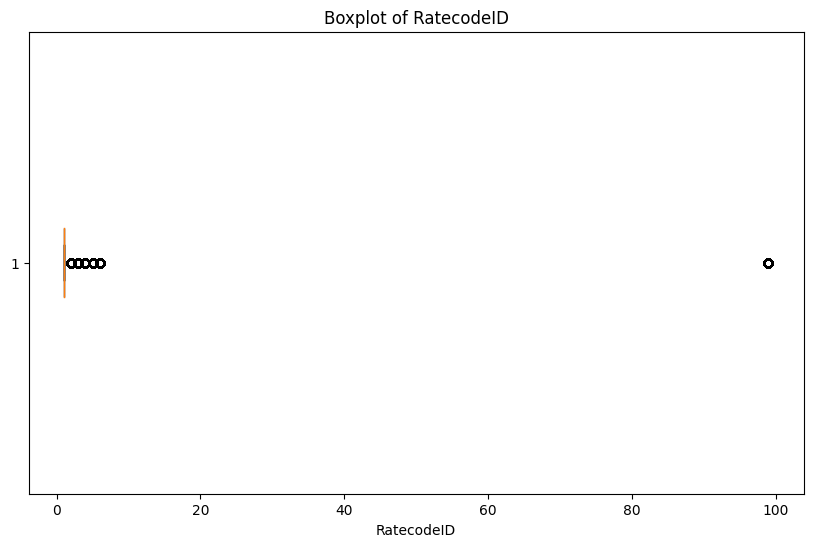

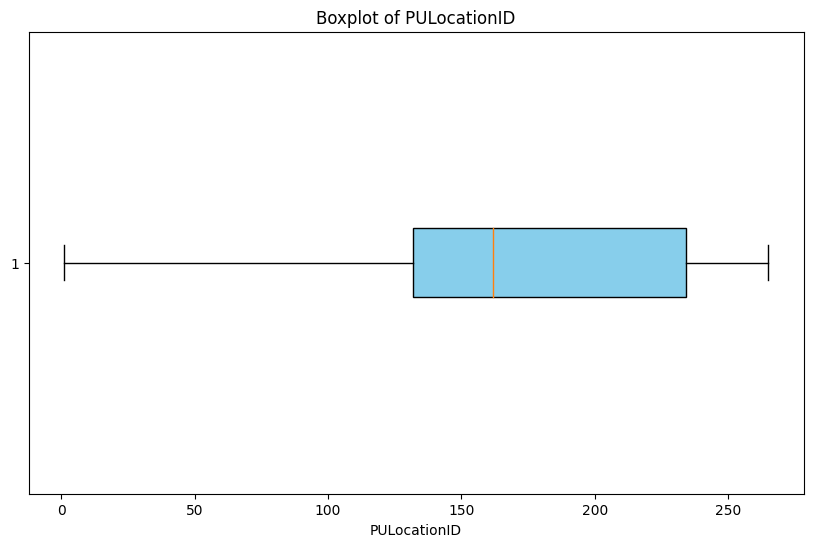

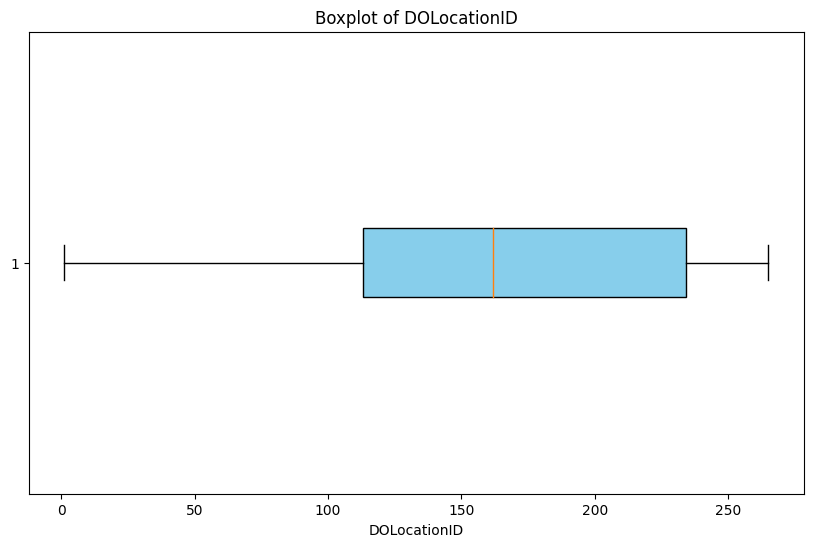

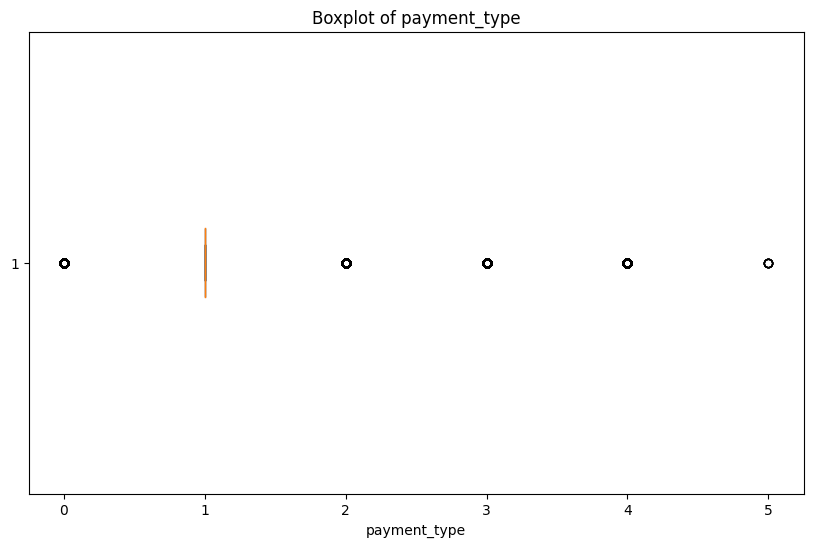

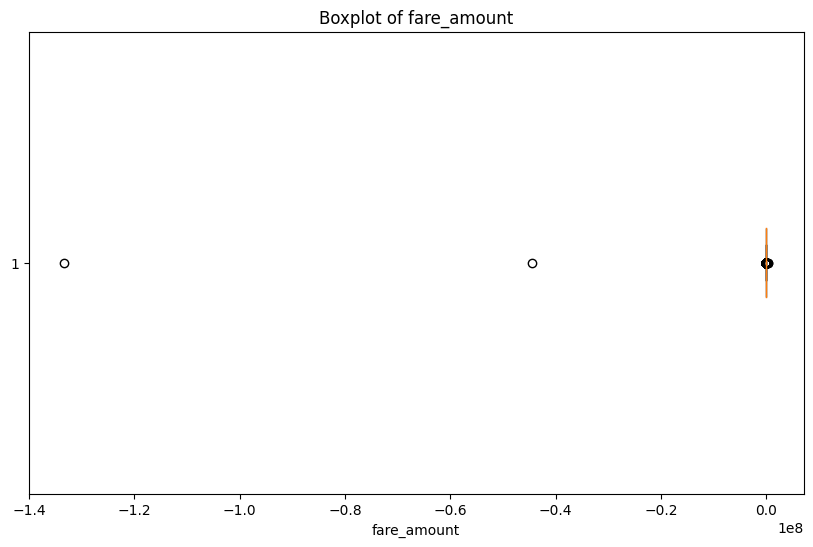

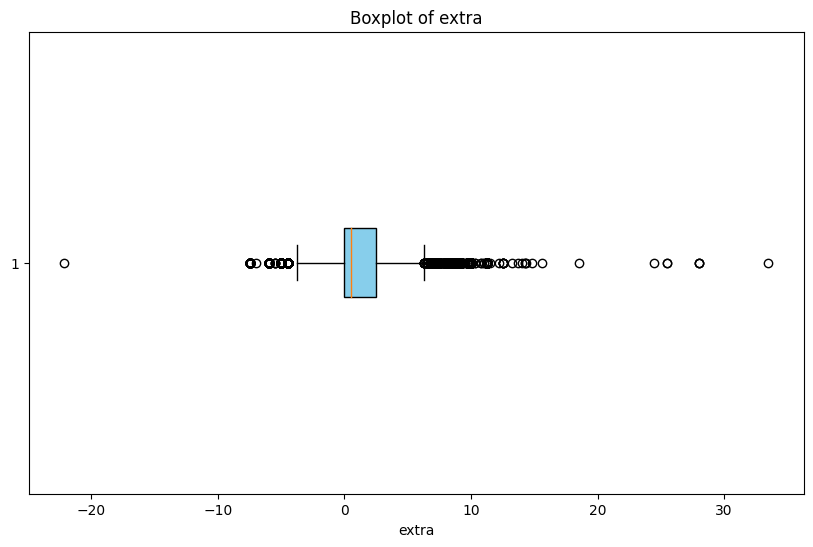

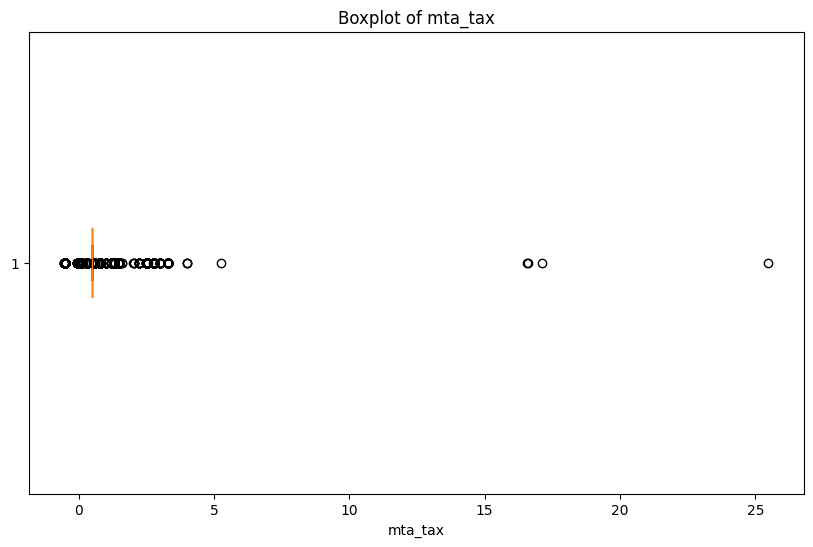

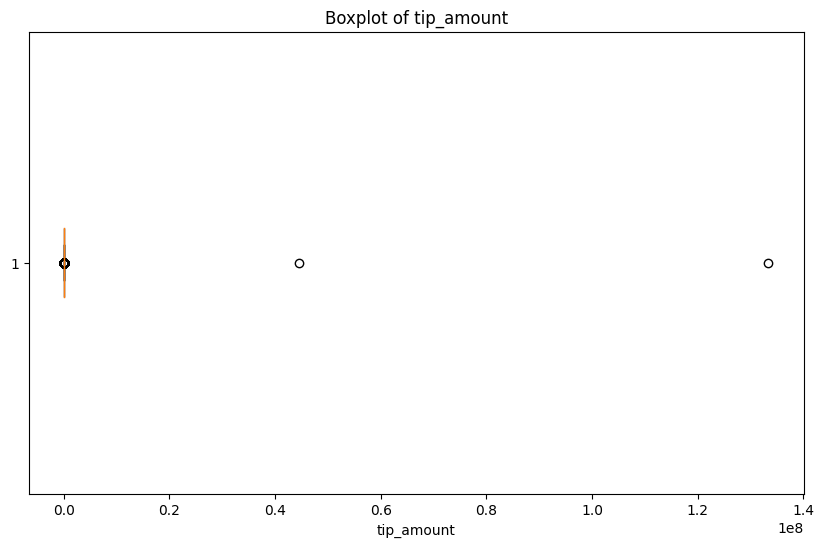

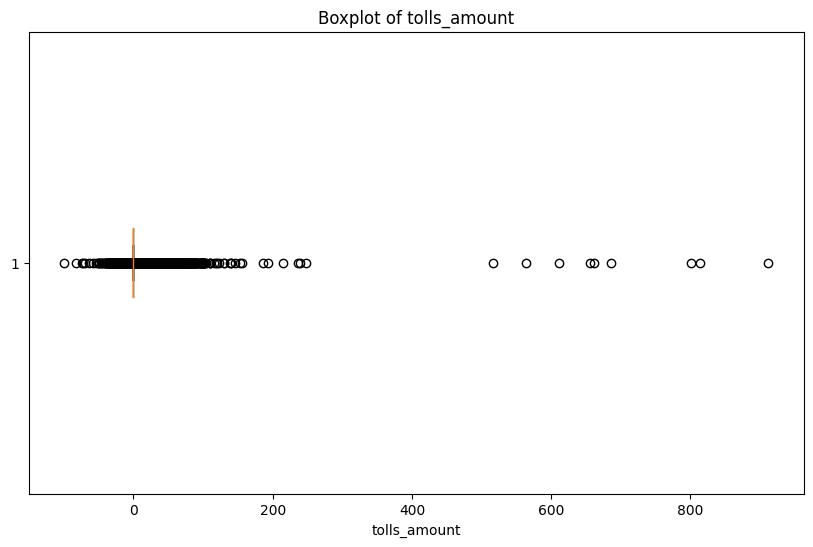

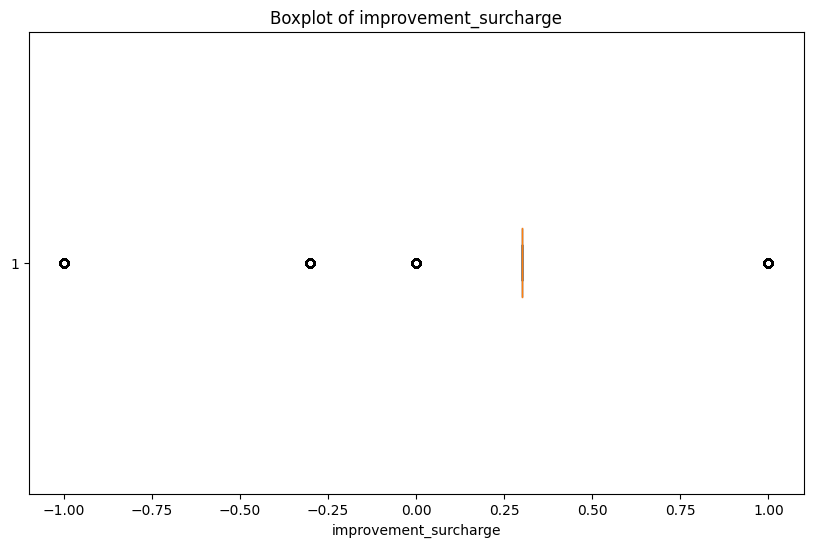

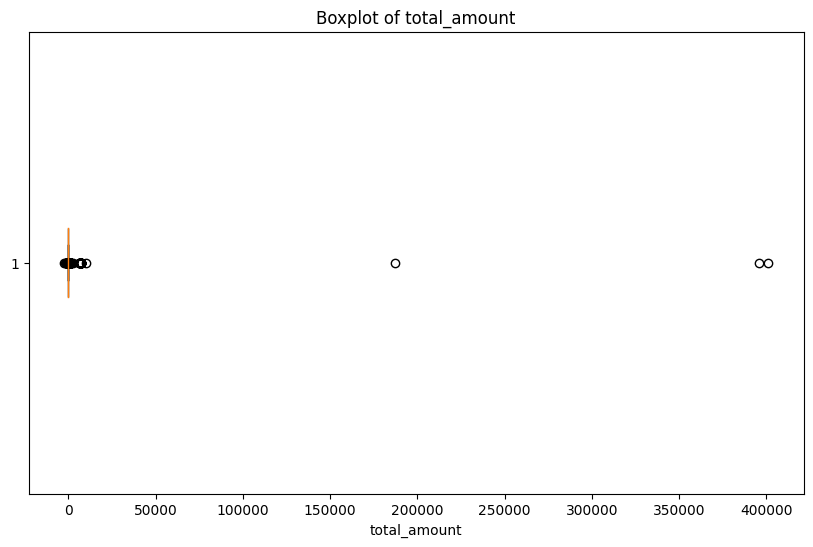

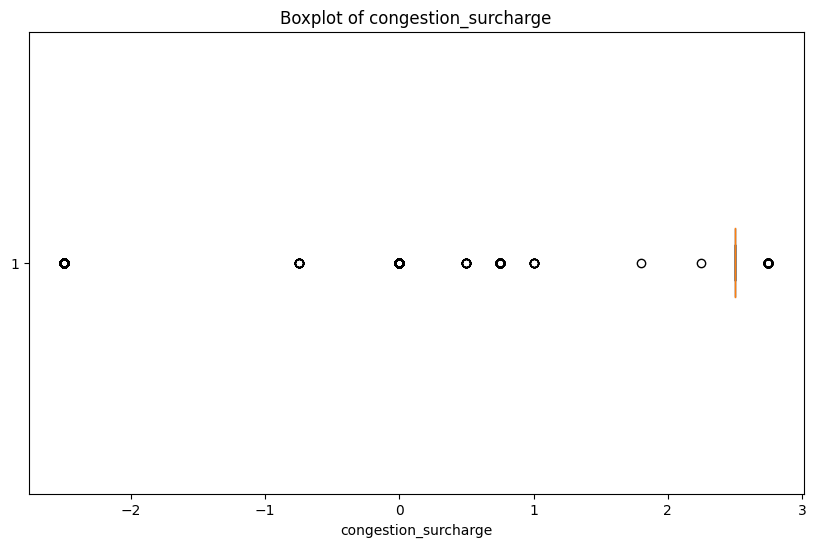

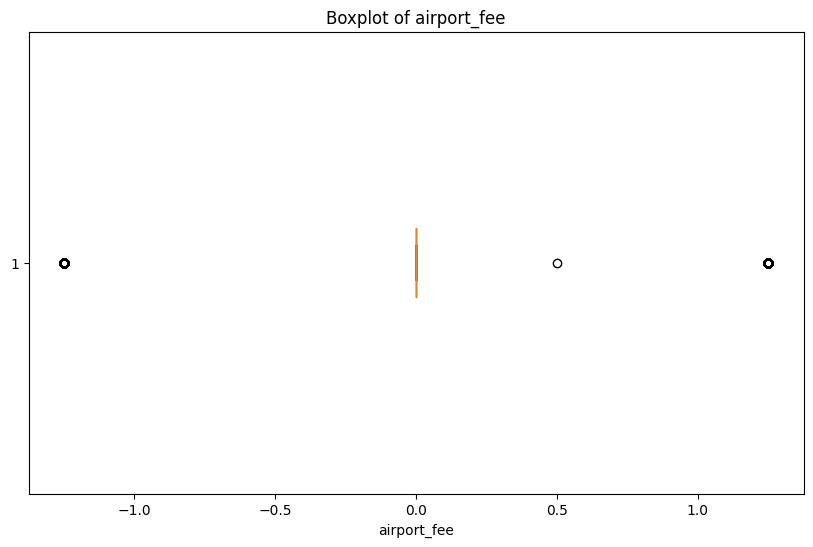

In [ ]:
import pandas as pd
from pathlib import Path
import os
import matplotlib.pyplot as plt
from typing import Optional

# Debug working directory
print(f"Current working directory: {os.getcwd()}")

# Define absolute path for data
data_path = Path("C:/Users/nahun/OneDrive/Escritorio/Anyone/Final Project - NYC Taxi Fare and Trip Duration Prediction/nyc-taxi-predictor/data/raw").resolve()
print(f"Resolved data path: {data_path}")

class DataLoader:
    def __init__(self, 
                 data_path: str, 
                 year: Optional[str] = None, 
                 month: Optional[str] = None
    ):
        self.data_path = data_path
        self.year = year
        self.month = month
        self.df = None

    def load_data(self) -> pd.DataFrame:
        """Load the dataset from the specified path."""
        try:
            data_path = Path(self.data_path)
            
            # If data_path is a directory, find matching files
            if data_path.is_dir():
                pattern = f"*_{self.year}-*.parquet" if self.year else f"*-{self.month}.parquet" if self.month else "*.parquet"
                files = list(data_path.glob(pattern))

                if not files:
                    raise FileNotFoundError(f"No matching files found for pattern: {pattern}")
                
                print(f"Found {len(files)} matching files: {[f.name for f in files]}")

                dfs = []
                for file in files:
                    try:
                        df = pd.read_parquet(file)
                        dfs.append(df)
                    except Exception as e:
                        print(f"Error reading file {file}: {str(e)}")
                
                if not dfs:
                    raise RuntimeError("No data could be loaded from matching files")
                
                self.df = pd.concat(dfs, ignore_index=True)
                
            else:
                # If data_path is a file, read it directly
                self.df = pd.read_parquet(data_path)
            
            print(f"Loaded dataset with shape: {self.df.shape}")
            return self.df
        except Exception as e:
            raise RuntimeError(f"Failed to load data: {e}")

# Initialize DataLoader and try loading the data
data_loader = DataLoader(data_path=str(data_path), year="2022", month="5")

try:
    df = data_loader.load_data()
    
    # Display dataframe in a more user-friendly table format with the first few rows
    from IPython.display import display
    
    # Display dataframe with better style
    display(df.head())  # Display the first 5 rows in the notebook (table format)
    
    # Optionally, show column names in a user-friendly way
    print(f"Column names: {df.columns.tolist()}")  # Print column names

    # Display full information about the dataframe (data types and null counts)
    print(f"Dataframe info (data types and non-null counts):")
    print(df.info())

except RuntimeError as e:
    print(f"Error: {e}")

# Plotting numerical columns using boxplots
numerical_columns = df.select_dtypes(include=["float64", "int64"]).columns

for col in numerical_columns:
    plt.figure(figsize=(10, 6))
    plt.boxplot(df[col].dropna(), vert=False, patch_artist=True, boxprops=dict(facecolor="skyblue"))
    plt.title(f"Boxplot of {col}")
    plt.xlabel(col)
    plt.show()


Current working directory: c:\Users\nahun\OneDrive\Escritorio\Anyone\Final Project - NYC Taxi Fare and Trip Duration Prediction\nyc-taxi-predictor\notebooks
Resolved data path: C:\Users\nahun\OneDrive\Escritorio\Anyone\Final Project - NYC Taxi Fare and Trip Duration Prediction\nyc-taxi-predictor\data\raw
Found 12 matching files: ['yellow_tripdata_2022-01.parquet', 'yellow_tripdata_2022-02.parquet', 'yellow_tripdata_2022-03.parquet', 'yellow_tripdata_2022-04.parquet', 'yellow_tripdata_2022-05.parquet', 'yellow_tripdata_2022-06.parquet', 'yellow_tripdata_2022-07.parquet', 'yellow_tripdata_2022-08.parquet', 'yellow_tripdata_2022-09.parquet', 'yellow_tripdata_2022-10.parquet', 'yellow_tripdata_2022-11.parquet', 'yellow_tripdata_2022-12.parquet']
Loaded dataset with shape: (39656098, 19)


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
28,2,2022-01-01 18:04:06,2022-01-01 18:40:52,1.0,9.70,1.0,N,138,48,1,34.5,0.50,0.5,9.22,6.55,0.3,55.32,2.5,1.25
33,2,2022-01-01 00:17:55,2022-01-01 00:27:45,1.0,4.22,1.0,N,138,92,2,14.0,0.50,0.5,0.00,0.00,0.3,16.55,0.0,1.25
34,2,2022-01-01 00:55:48,2022-01-01 01:14:24,1.0,6.67,1.0,N,138,229,1,21.0,0.50,0.5,15.00,0.00,0.3,41.05,2.5,1.25
38,1,2022-01-01 00:10:27,2022-01-01 00:41:59,1.0,17.10,2.0,N,132,170,1,52.0,3.75,0.5,15.75,6.55,0.3,78.85,2.5,1.25
40,2,2022-01-01 00:50:27,2022-01-01 00:59:28,1.0,2.66,1.0,N,132,10,2,10.0,0.50,0.5,0.00,0.00,0.3,12.55,0.0,1.25


Column names: ['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'airport_fee']
Dataframe info (data types and non-null counts):
<class 'pandas.core.frame.DataFrame'>
Index: 3012466 entries, 28 to 39529624
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type          

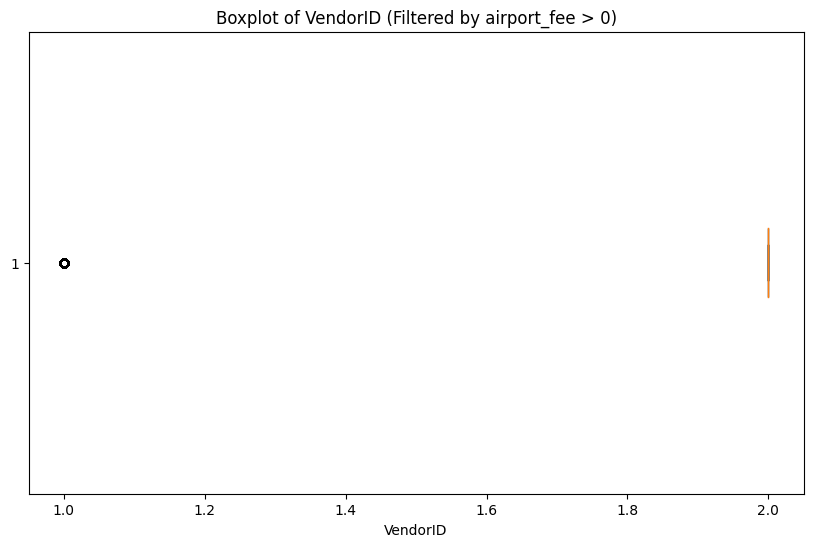

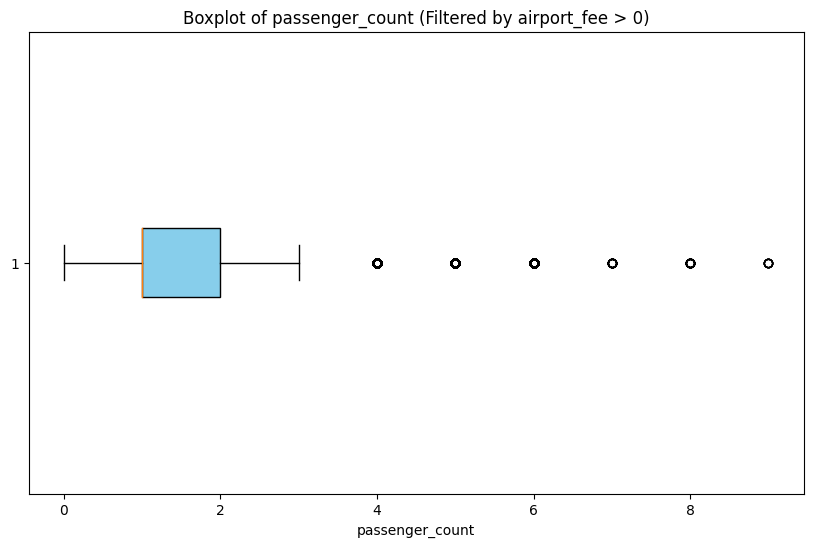

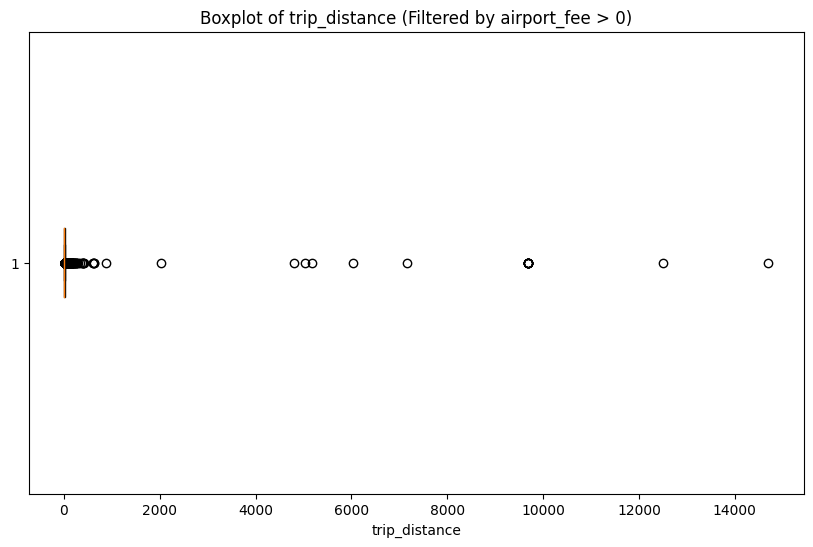

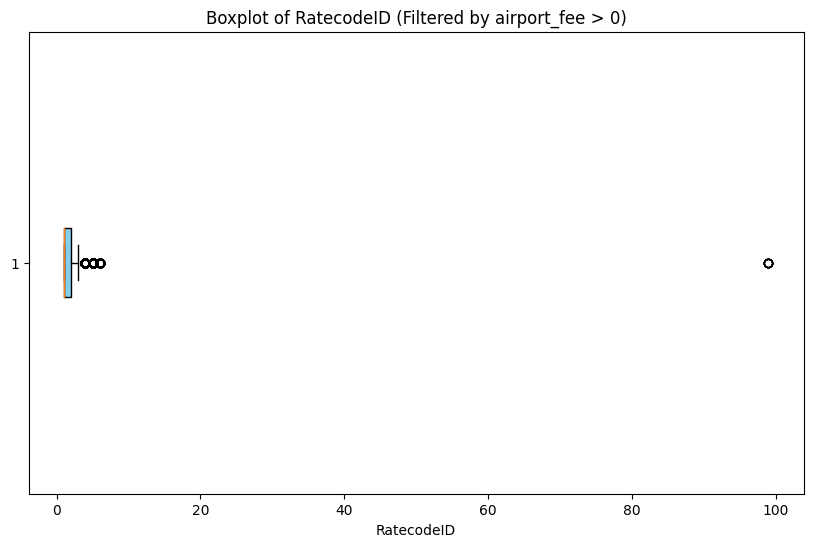

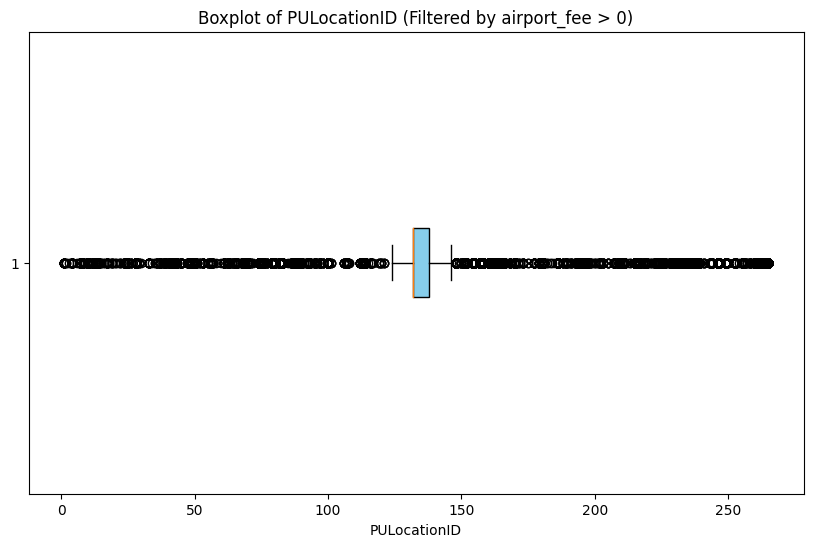

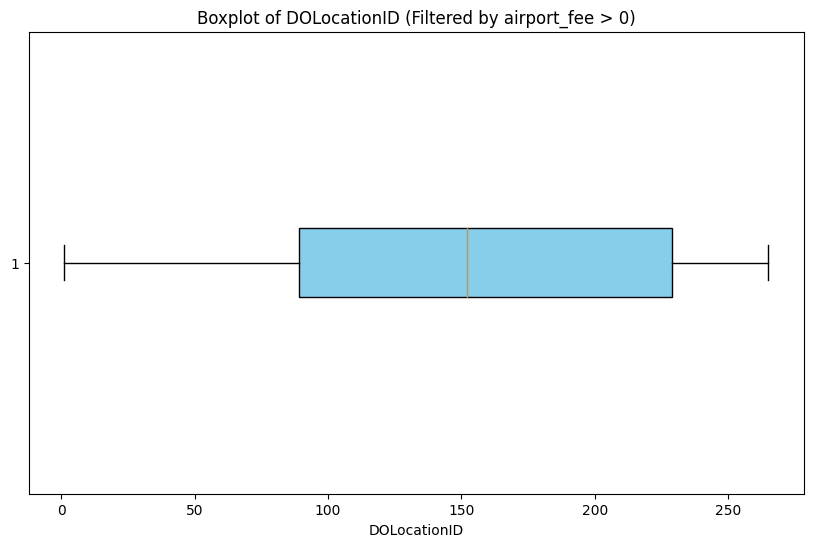

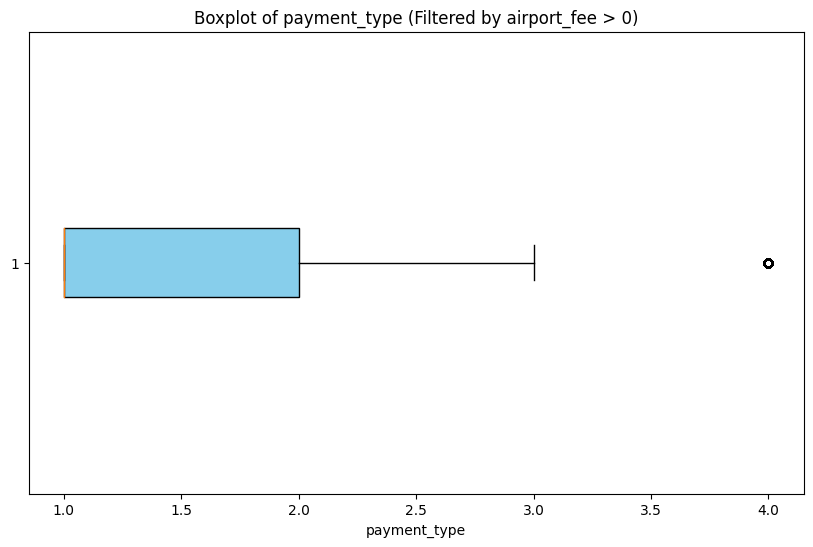

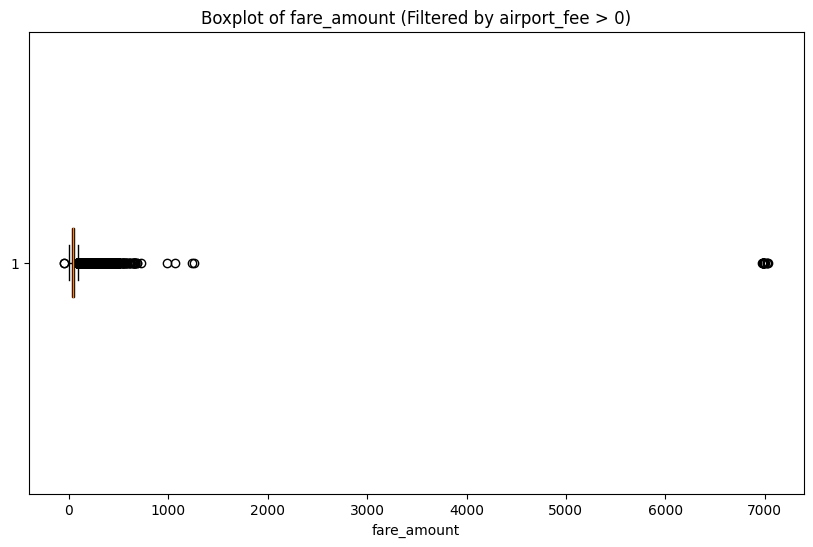

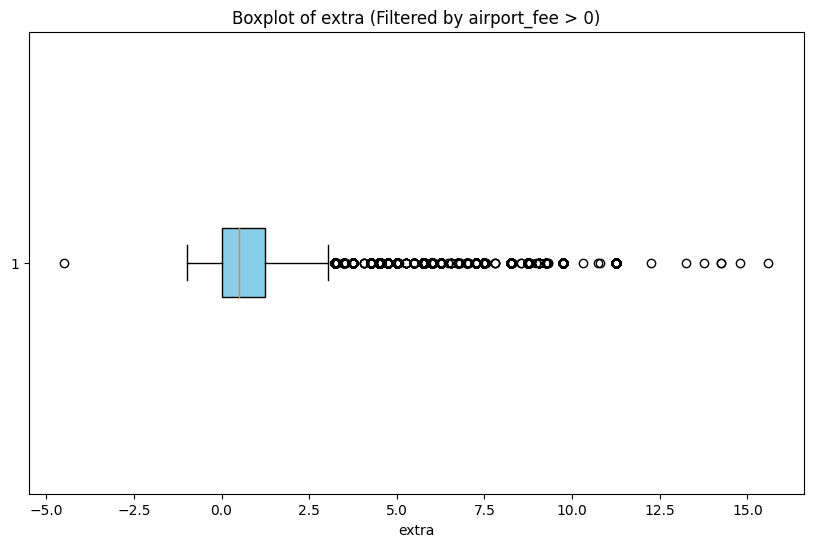

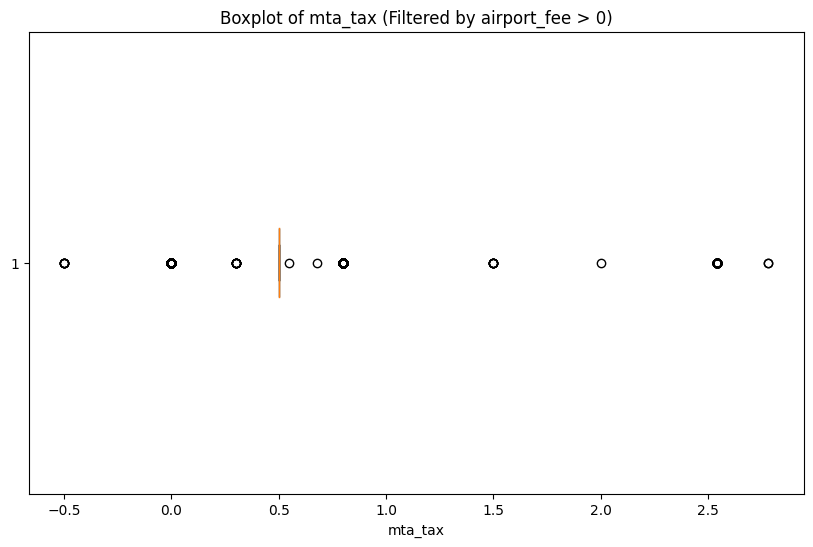

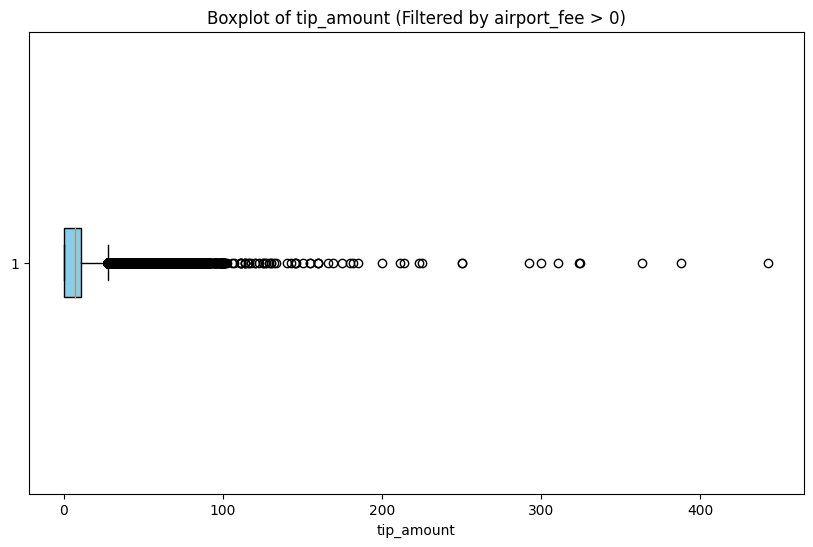

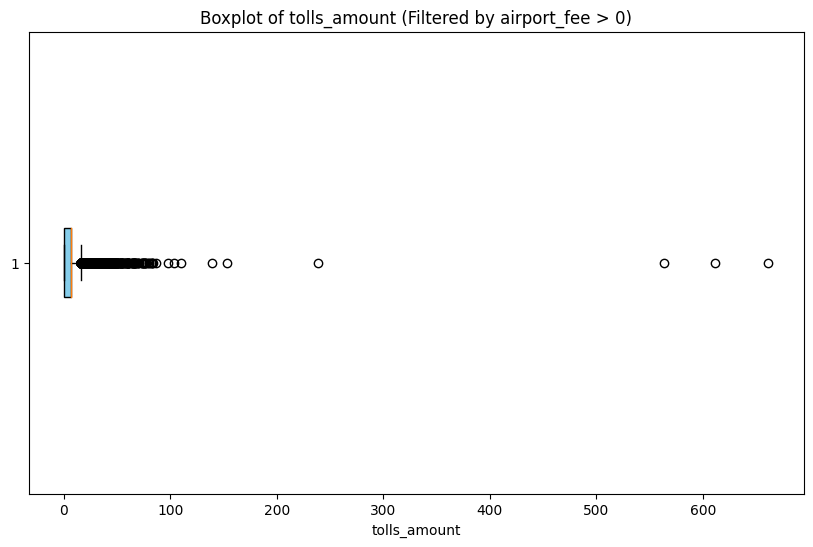

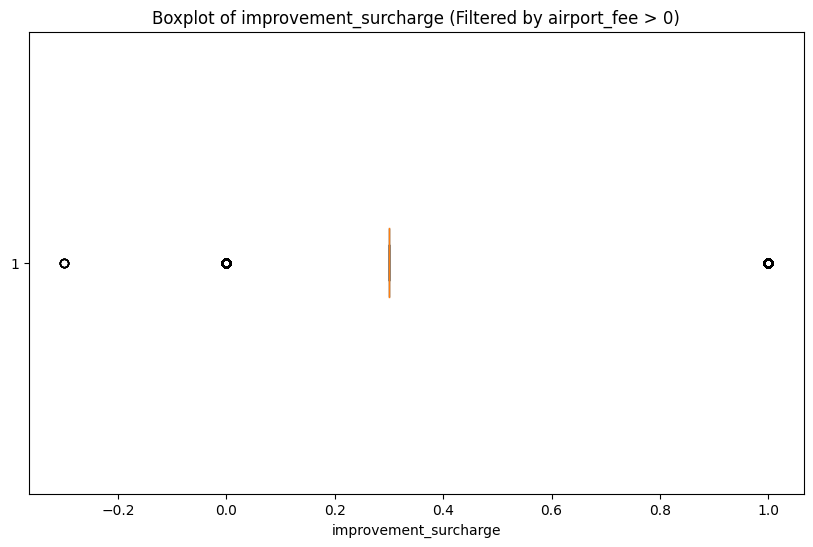

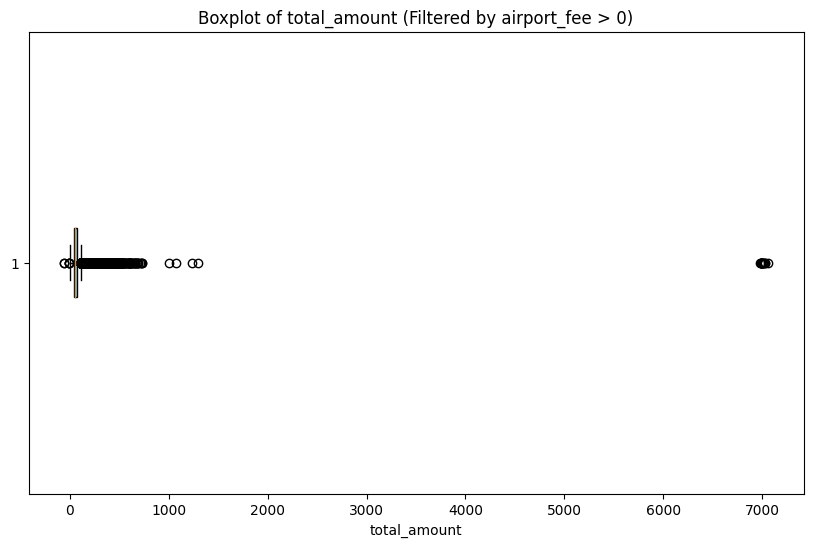

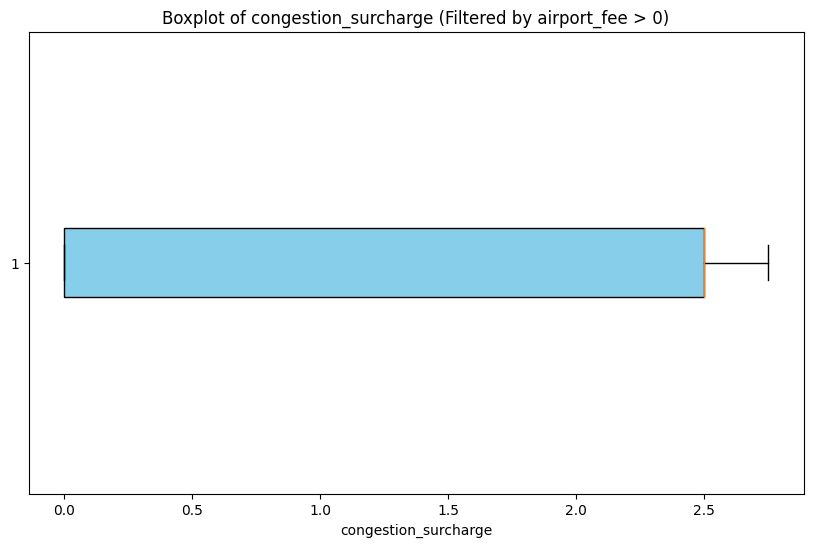

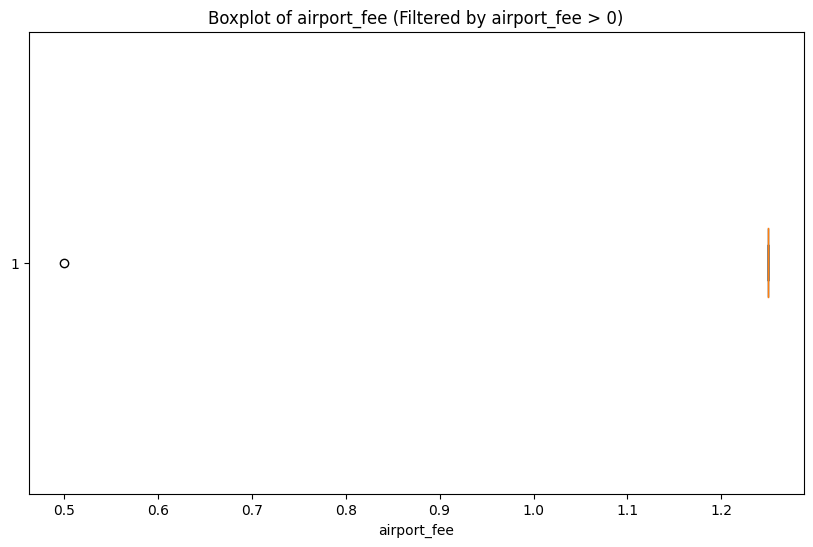

In [1]:

import pandas as pd
from pathlib import Path
import os
import matplotlib.pyplot as plt
from typing import Optional

# Debug working directory
print(f"Current working directory: {os.getcwd()}")

# Define absolute path for data
data_path = Path("C:/Users/nahun/OneDrive/Escritorio/Anyone/Final Project - NYC Taxi Fare and Trip Duration Prediction/nyc-taxi-predictor/data/raw").resolve()
print(f"Resolved data path: {data_path}")

class DataLoader:
    def __init__(self, 
                 data_path: str, 
                 year: Optional[str] = None, 
                 month: Optional[str] = None
    ):
        self.data_path = data_path
        self.year = year
        self.month = month
        self.df = None

    def load_data(self) -> pd.DataFrame:
        """Load the dataset from the specified path."""
        try:
            data_path = Path(self.data_path)
            
            # If data_path is a directory, find matching files
            if data_path.is_dir():
                pattern = f"*_{self.year}-*.parquet" if self.year else f"*-{self.month}.parquet" if self.month else "*.parquet"
                files = list(data_path.glob(pattern))

                if not files:
                    raise FileNotFoundError(f"No matching files found for pattern: {pattern}")
                
                print(f"Found {len(files)} matching files: {[f.name for f in files]}")

                dfs = []
                for file in files:
                    try:
                        df = pd.read_parquet(file)
                        dfs.append(df)
                    except Exception as e:
                        print(f"Error reading file {file}: {str(e)}")
                
                if not dfs:
                    raise RuntimeError("No data could be loaded from matching files")
                
                self.df = pd.concat(dfs, ignore_index=True)
                
            else:
                # If data_path is a file, read it directly
                self.df = pd.read_parquet(data_path)
            
            print(f"Loaded dataset with shape: {self.df.shape}")
            return self.df
        except Exception as e:
            raise RuntimeError(f"Failed to load data: {e}")

# Initialize DataLoader and try loading the data
data_loader = DataLoader(data_path=str(data_path), year="2022", month="5")

try:
    df = data_loader.load_data()
    
    # Filter the dataset for rows where 'Airport_fee' > 0
    df_filtered = df[df['airport_fee'] > 0]

    # Display dataframe in a more user-friendly table format with the first few rows
    from IPython.display import display
    
    # Display filtered dataframe
    display(df_filtered.head())  # Display the first 5 rows of the filtered dataset
    
    # Optionally, show column names in a user-friendly way
    print(f"Column names: {df_filtered.columns.tolist()}")  # Print column names

    # Display full information about the filtered dataframe (data types and null counts)
    print(f"Dataframe info (data types and non-null counts):")
    print(df_filtered.info())

except RuntimeError as e:
    print(f"Error: {e}")

# Plotting numerical columns using boxplots for the filtered data
numerical_columns = df_filtered.select_dtypes(include=["float64", "int64"]).columns

for col in numerical_columns:
    plt.figure(figsize=(10, 6))
    plt.boxplot(df_filtered[col].dropna(), vert=False, patch_artist=True, boxprops=dict(facecolor="skyblue"))
    plt.title(f"Boxplot of {col} (Filtered by airport_fee > 0)")
    plt.xlabel(col)
    plt.show()
